In [1]:
from dataloader import ReyesDataset
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np

In [2]:
# timer inicial do notebook
import time
start = time.time()

In [3]:
train = ReyesDataset("../dataset/UCI/train.csv")
print(train.X.shape)
# calcula o hierariquico de X
Z = linkage(train.X[:,0,:].reshape(train.X.shape[0],train.X.shape[-1]), 'ward')

(7352, 9, 128)


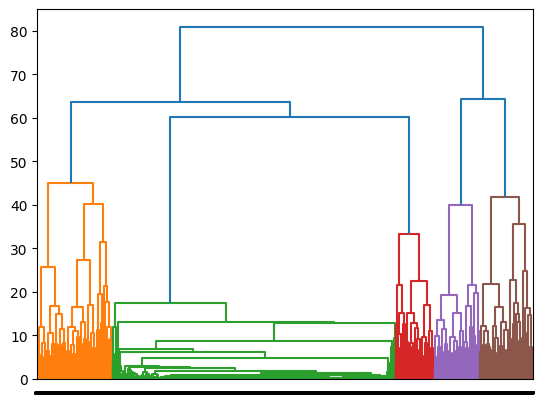

<Figure size 2500x1000 with 0 Axes>

In [4]:
dendrogram(Z, labels=train.Y)

plt.figure(figsize=(25, 10))
plt.show()

In [5]:
def plotar_grupo(grupo, embeddings, labels):
    intervalo_x = [np.min(embeddings[:,0]), np.max(embeddings[:,0])]
    intervalo_y = [np.min(embeddings[:,1]), np.max(embeddings[:,1])]

    names = {0: 'WALKING', 1: 'WALKING UPSTAIRS', 2: 'WALKING DOWNSTAIRS', 3: 'SITTING', 4: 'STANDING', 5: 'LAYING', 6: 'RUNNING'}
    colors = {0: 'darkorange', 1: 'magenta', 2: 'purple', 3: 'blue', 4: 'green', 5: 'brown', 6: 'red'}

    # traduz labels para um vetor de RGB
    labels = np.array([colors[label] for label in labels])
    print(labels.shape)

    plt.scatter(embeddings[grupo,0], embeddings[grupo,1], c=labels[grupo], alpha=0.5,)
    # mostra a legenda com base nos nomes
    for i in range(7):
        plt.scatter([], [], c=colors[i], label=names[i])

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
    plt.xlim(intervalo_x)
    plt.ylim(intervalo_y)
    plt.show()


def plotar_completo(X_embedded_latent, labels):

    # imita o funcionamento da funcao acima
    intervalo_x = [np.min(X_embedded_latent[:,0]), np.max(X_embedded_latent[:,0])]
    intervalo_y = [np.min(X_embedded_latent[:,1]), np.max(X_embedded_latent[:,1])]

    names = {0: 'WALKING', 1: 'WALKING UPSTAIRS', 2: 'WALKING DOWNSTAIRS', 3: 'SITTING', 4: 'STANDING', 5: 'LAYING', 6: 'RUNNING'}
    colors = {0: 'darkorange', 1: 'magenta', 2: 'purple', 3: 'blue', 4: 'green', 5: 'brown', 6: 'red'}

    # traduz labels para um vetor de RGB
    labels = np.array([colors[label] for label in labels])

    plt.scatter(X_embedded_latent[:,0], X_embedded_latent[:,1], c=labels, alpha=0.5,)
    for i in range(7):
        plt.scatter([], [], c=colors[i], label=names[i])
        
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
    plt.xlim(intervalo_x)
    plt.ylim(intervalo_y)
    plt.show()


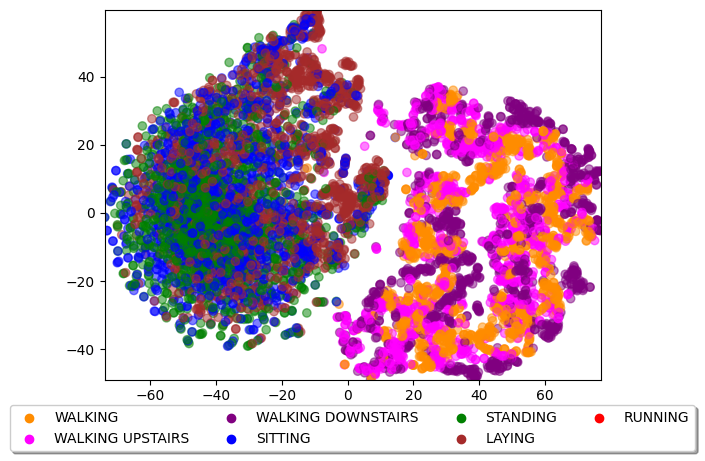

In [6]:
# mostra o tsne desses dados
from sklearn.manifold import TSNE

X = train.X[:,0,:].reshape(train.X.shape[0],train.X.shape[-1])
X_embedded = TSNE(n_components=2).fit_transform(X)
plotar_completo(X_embedded, train.Y)

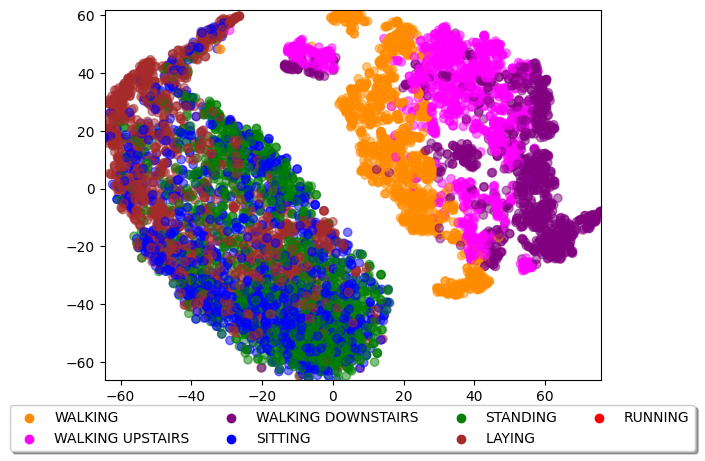

In [7]:
from scipy.fftpack import fft

X_freq = np.abs(fft(X))
X_freq = X_freq[:,1:X.shape[1]//2]
X_embedded_freq = TSNE(n_components=2).fit_transform(X_freq)
plotar_completo(X_embedded_freq, train.Y)

In [8]:
Z_freq = linkage(X_freq, 'ward')

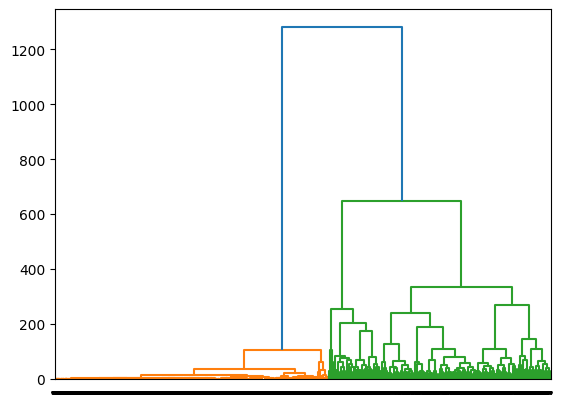

<Figure size 2500x1000 with 0 Axes>

In [9]:
dendrogram(Z_freq, labels=train.Y)

plt.figure(figsize=(25, 10))
plt.show()

In [10]:
import torch
import lightning as L
from tfc import NTXentLoss_poly, TFC_Model, TFC_Backbone
from dataloader import ReyesModule

# Build the pretext model, the pretext datamodule, and the trainer
pretext_model = TFC_Model(backbone=TFC_Backbone(), pred_head=None, loss = NTXentLoss_poly("cuda", 8, 0.2, True)) # batch size 8
pretext_datamodule = ReyesModule(root_data_dir=f"../dataset/UCI/", batch_size=8)
lightning_trainer = L.Trainer(
    accelerator="gpu",
    # max_epochs=40,
    max_epochs=1,
    max_steps=-1,
    enable_checkpointing=True, 
    logger=True)

# Fit the pretext model using the pretext_datamodule
lightning_trainer.fit(pretext_model, pretext_datamodule)

# Save the backbone weights
torch.save(pretext_model.backbone.state_dict(), "weights/pretrained_backbone_weights.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/nicolas/Programas/EpisodeTracker/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/nicolas/Programas/EpisodeTracker/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params | Mode 
-----------------------

Epoch 0:   0%|          | 0/919 [00:00<?, ?it/s] 

/home/nicolas/Programas/EpisodeTracker/code/tfc.py:242: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  mask = torch.cuda.FloatTensor(x.shape).uniform_() > maskout_ratio # maskout_ratio are False


Epoch 0: 100%|██████████| 919/919 [00:19<00:00, 47.63it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 919/919 [00:19<00:00, 47.56it/s, v_num=12]


In [11]:
print(train.X.shape)
print(train.Y.shape)

output = pretext_model(torch.tensor(train.X.astype(np.float32)))
# formato: h_t, z_t, h_f, z_f
# concatena z_t e z_f
latent = torch.cat((output[1], output[3]), dim=1)

(7352, 9, 128)
(7352,)


In [12]:
# mostra o espaço latente com as labels
X_embedded_latent = TSNE(n_components=2).fit_transform(latent.detach().numpy())

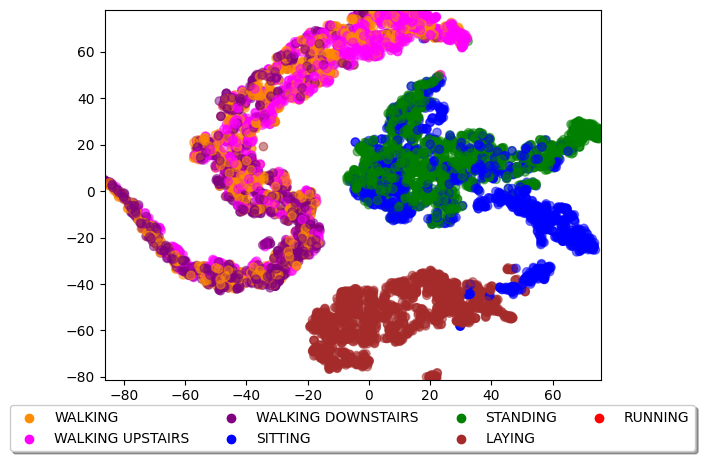

In [13]:
plotar_completo(X_embedded_latent, train.Y)

In [14]:
# calcula o hierariquico de latent
Z_latent = linkage(latent.detach().numpy(), 'ward')

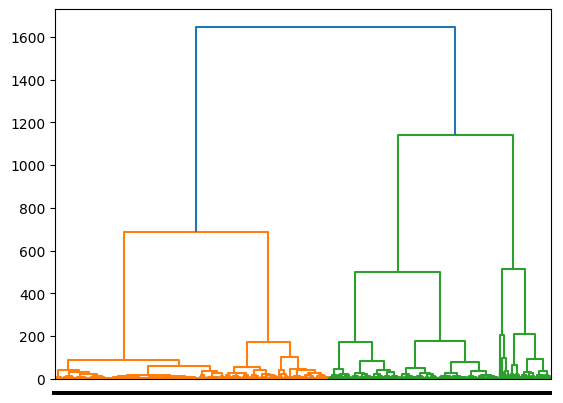

<Figure size 2500x1000 with 0 Axes>

In [15]:
# mostra o dendograma
dendrogram(Z_latent, labels=train.Y)

plt.figure(figsize=(25, 10))
plt.show()

In [16]:
# printa os grupos com o corte em 4 grupos
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z_latent, 4, criterion='maxclust')
# obtem os indices dos grupos
group1 = np.where(clusters == 1)[0]
group2 = np.where(clusters == 2)[0]
group3 = np.where(clusters == 3)[0]
group4 = np.where(clusters == 4)[0]

(7352,)


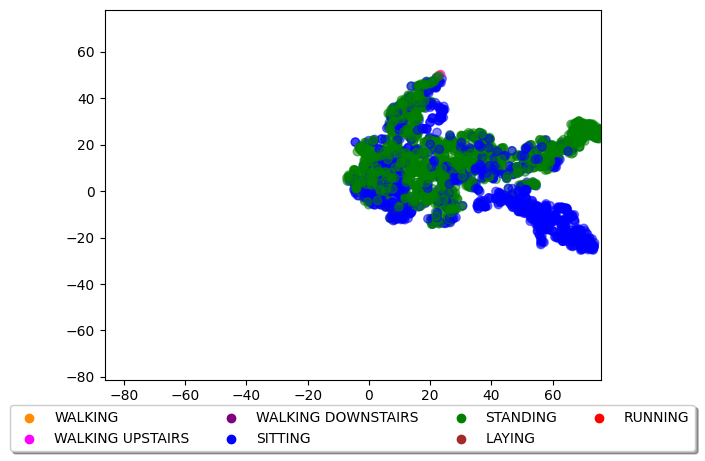

(7352,)


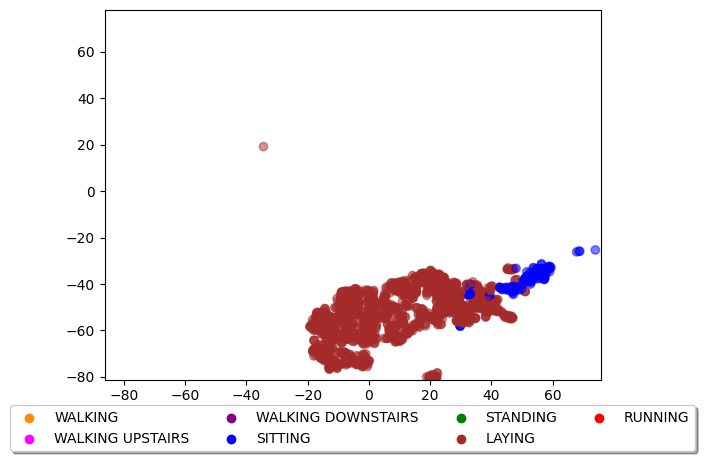

(7352,)


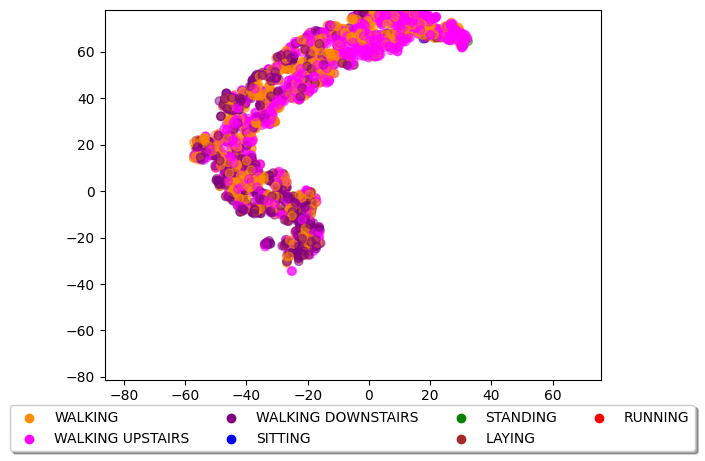

(7352,)


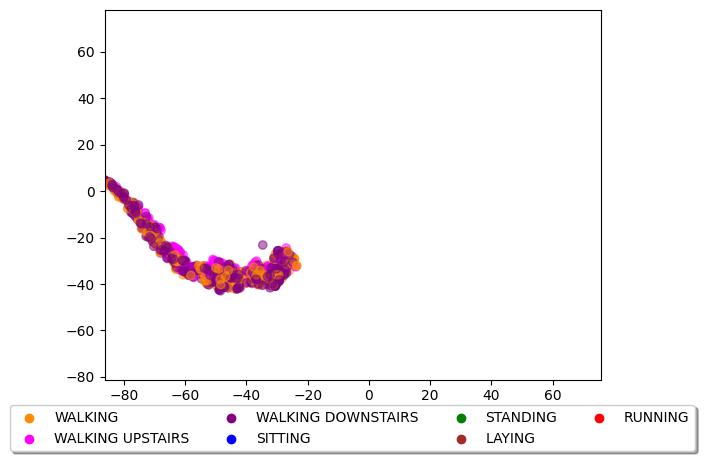

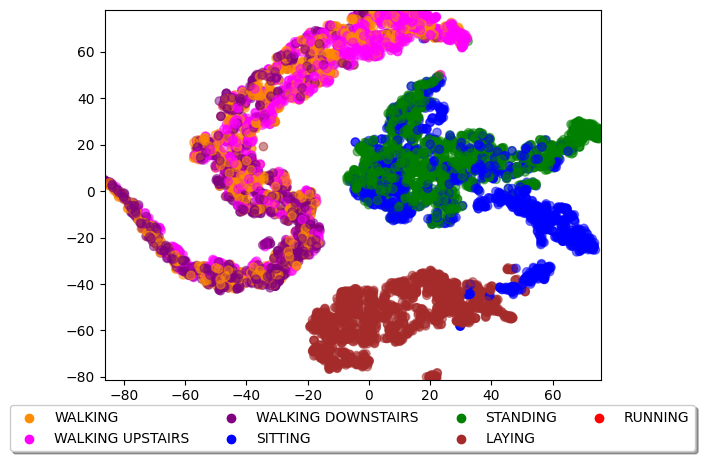

In [17]:
plotar_grupo(group1, X_embedded_latent, train.Y)
plotar_grupo(group2, X_embedded_latent, train.Y)
plotar_grupo(group3, X_embedded_latent, train.Y)
plotar_grupo(group4, X_embedded_latent, train.Y)

plotar_completo(X_embedded_latent, train.Y)

